In [3]:
import SimpleITK as sitk
from pylab import *
from scipy import ndimage
%matplotlib inline

# define some helpers here
def plotImage(imageFile,x,y,z, bmedian=False):
    inputImage = sitk.ReadImage(imageFile)
    data = sitk.GetArrayFromImage(inputImage)
    if bmedian:
        data = ndimage.filters.median_filter(data,3)
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(18.5, 10.5)
    axs[0].imshow(data[x,:,:],interpolation="nearest", cmap = 'gray')
    axs[0].set_axis_off()
    axs[1].imshow(np.flipud(data[:,y,:]),interpolation="nearest", cmap = 'gray')
    axs[1].set_axis_off()
    axs[2].imshow(np.flipud(data[:,:,z]),interpolation="nearest", cmap = 'gray')
    axs[2].set_axis_off()
    
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [2]:
# define the paths to datasets
PTHORIG = '/home/disk1/alfiia//BRATS2015_Training/original'
PTHPREP = PTHORIG + '_NS'#'_BFC_HMF4'
# PTHORIG = '/home/ssd/alfiia/BRATS2015_Training/original'
# PTHPREP = PTHORIG + '_BFC'

/home/disk1/alfiia//BRATS2015_Training/original_NS/LGG/brats_tcia_pat241_0001/VSD.Brain.XX.O.MR_Flair.40931/VSD.Brain.XX.O.MR_Flair.40931.mha


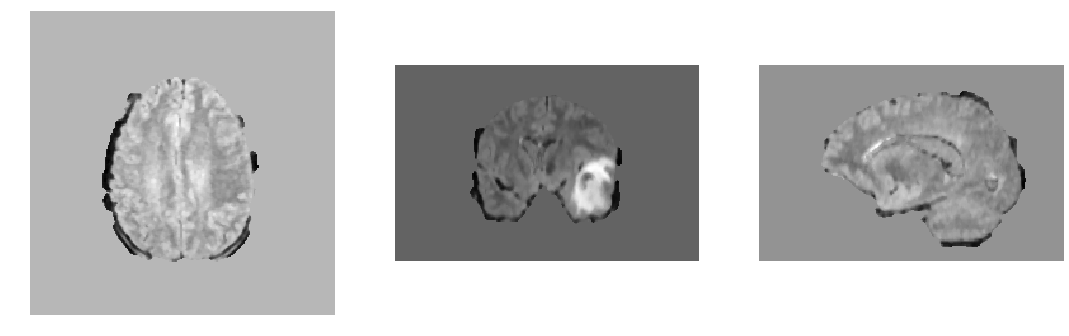

In [10]:
# load the BRATS data and view 
import SimpleITK as sitk
from pylab import *
%matplotlib inline
import preprocessor as prep


bratsDB = prep.loadBRATS(PTHPREP)

stype = 'LGG'; icase = 19; smod = 'FLAIR'
imageFile = '%s/%s'%(PTHPREP,bratsDB[stype][icase][smod])
print imageFile

x,y,z = 100,100,100
plotImage(imageFile,x,y,z, bmedian=True)

In [6]:
# get some patches 
stype = 'HGG'
icase = 0
listFile = {}
for smod in {'T1','T1c','T2','FLAIR','GT'}:
    listFile[smod] = '%s/%s'%(PTHPREP,bratsDB[stype][icase][smod])

patchSize = 15

#patches,labels,_ = prep.patchGenerator(listFile,patchSize,patchtype='axial')
patchesA,patchesC,patchesS,labels,_ = prep.patchGenerator(listFile,patchSize,patchtype='triplanar')
print patchesA.shape

(40763, 4, 15, 15)


1


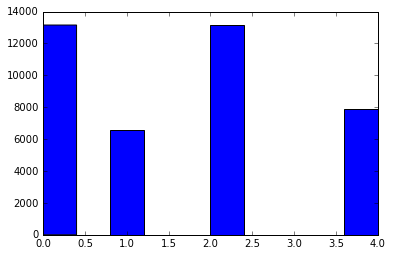

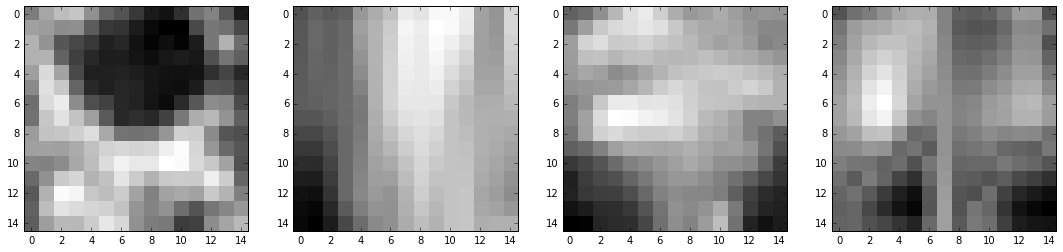

In [11]:
# view the patches and label frequencies
x = 10000
print labels[x]
hist(labels)
fig, axs = plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
patches = patchesC
axs[0].imshow(patches[x,0,:,:],interpolation="nearest", cmap = 'gray')
axs[1].imshow(patches[x,1,:,:],interpolation="nearest", cmap = 'gray')
axs[2].imshow(patches[x,2,:,:],interpolation="nearest", cmap = 'gray')
axs[3].imshow(patches[x,3,:,:],interpolation="nearest", cmap = 'gray')

In [17]:
from preprocessor import _patchSampler

def _patchExtractor(inputFile, GTFile, masktype='brainmask', stride=2, minclass=0.01, bzscores=False):
    
    inputImage = sitk.ReadImage(inputFile)
    data = sitk.GetArrayFromImage(inputImage)
    
    if bzscores:
        IC=ndimage.filters.median_filter(data,3)!=0 # intracranial volume
    else:
        IC=ndimage.filters.median_filter(data,3)>0
        
    if not masktype == 'all':
        GTImage = sitk.ReadImage(GTFile)
        maskGT = sitk.GetArrayFromImage(GTImage)
    if masktype == 'brainmask':
        chess = _patchSampler(GTFile,s=stride)
        chessNABS = _patchSampler(GTFile,s=4,bRandom=True)
        mask = (chess>0) & (maskGT>0) | ((chessNABS>0) & (maskGT==0) & (IC>0))
    elif masktype == 'bbox':
        chess = _patchSampler(GTFile,s=2)
        [IZ,IR,IC]=np.where(maskGT>0)
        minZ = min(IZ)
        minR = min(IR)
        minC = min(IC)

        maxZ = max(IZ)
        maxR = max(IR)
        maxC = max(IC)

        bbox = np.zeros(maskGT.shape)
        bbox[range(minZ,maxZ),:,:]=1
        bbox[:,range(minR,maxR)]+=1
        bbox[:,:,range(minC,maxC)]+=1

        mask = (chess>0) & (bbox>2) & (IC>0)
    elif masktype == 'all':#for segmentation test
        mask = (IC>0)

    if not masktype == 'all':
        # remove the under-respresented:
        for lab in unique(maskGT.flatten()):
            if float(sum(maskGT == lab))/sum(maskGT>0) < minclass:
                mask[maskGT == lab] = 0

    return mask

def n_patchGenerator(listFile, patchSize, patchtype='axial', masktype='brainmask',outputFile='', maxratio=2):
    assert(not patchSize % 2 == 0)
    nChannels = 4 #'FLAIR','T1c','T2','T1'
    PS = patchSize/2
    imageFile = listFile['T2']
    GTFile = listFile['GT']

    GT = sitk.ReadImage(listFile['GT'])
    GT = sitk.GetArrayFromImage(GT)

    mask = _patchExtractor(imageFile, GTFile, masktype, bzscores=True)

    # balance the classes if wanted
    if maxratio>0:
        labs = unique(GT[mask>0])
        cards = dict.fromkeys(labs,0)
        for lab in labs:
            cards[lab]=sum(GT[mask>0]==lab)
        maxcard = min(cards.values())*maxratio
        for lab in labs:
            # delete the exceeding points randomly
            delcard = max(0,cards[lab]-maxcard)
            if delcard>0:
                inds = np.arange(cards[lab])
                shuffle(inds)
                inds = inds[:delcard]
                _mask = (GT==lab) & (mask>0)
                INDS = np.flatnonzero(_mask)
                mask[np.unravel_index(INDS[inds],_mask.shape)]=0

    [IZZ,IRR,ICC] = np.where(mask>0)
    npatch = size(IZZ)

    # if needed, record directly to the output file
    if not outputFile=='':
        import h5py
        with h5py.File(outputFile,'w') as patchFile:
            if patchtype in {'axial','coronal','sagittal','triplanar'}:
                _datashape = [npatch,nChannels,patchSize,patchSize]
            #elif patchtype=='triplanar':
            #    _datashape = [npatch,nChannels*3,patchSize,patchSize]
            elif patchtype=='3D':
                _datashape = [npatch,nChannels,patchSize,patchSize,patchSize]
            patches = patchFile.create_dataset('data', shape=_datashape,dtype='float32')
            _labelshape = [npatch]
            labels = patchFile.create_dataset('labels', shape=_labelshape,dtype='uint8')
    else:
        if patchtype=='axial' or patchtype=='coronal' or patchtype=='sagittal':
            patches = np.zeros(shape=(npatch,nChannels,patchSize, patchSize))
        elif patchtype=='triplanar':
            #patches = np.zeros(shape=(npatch,nChannels*3,patchSize, patchSize))
            patchesA = np.zeros(shape=(npatch,nChannels,patchSize, patchSize))
            patchesC = np.zeros(shape=(npatch,nChannels,patchSize, patchSize))
            patchesS = np.zeros(shape=(npatch,nChannels,patchSize, patchSize))
        elif patchtype=='3D':
            patches = np.zeros(shape=(npatch,nChannels,patchSize, patchSize,patchSize))

    imageChannelCount = 0
    for smod in {'FLAIR','T1c','T2','T1'}:
        inputImage = sitk.ReadImage(listFile[smod])
        nda = np.float32(sitk.GetArrayFromImage(inputImage))
        # compute z-scores ('standardization')
        ind = np.where(nda>0)
        nda[ind] = (nda[ind] - np.mean(nda[ind]))/(np.std(nda[ind])+np.finfo(float).eps)
        nda = np.lib.pad(nda,((PS,PS),(PS,PS),(PS,PS)), 'constant',constant_values=(0,0))
        for ipatch in range(npatch):
            z = IZZ[ipatch]+PS; i = IRR[ipatch]+PS; j = ICC[ipatch]+PS
            if patchtype=='axial':
                patches[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
            elif patchtype=='coronal':
                patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
            elif patchtype=='sagittal':
                patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
            elif patchtype=='triplanar':
                patchesA[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                patchesC[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                patchesS[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                #patches[ipatch,imageChannelCount*3,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                #patches[ipatch,imageChannelCount*3+1,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                #patches[ipatch,imageChannelCount*3+2,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
            elif patchtype=='3D':
                patches[ipatch,imageChannelCount,:,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j-PS:j+PS+1]

            ipatch +=1
        imageChannelCount += 1

    labels = GT[mask>0]
    if patchtype=='triplanar':
        return patchesA,patchesC,patchesS, labels, mask
    else:
        return patches, labels, mask

In [45]:
# get the images and GTs
stype = 'LGG'
icase = 19
listFile = {}
for smod in {'T1','T1c','T2','FLAIR','GT'}:
    listFile[smod] = '%s/%s'%(PTHPREP,bratsDB[stype][icase][smod])
imageFile = listFile['T2']
GTFile = listFile['GT']
# mask = _patchExtractor(imageFile, GTFile, masktype='brainmask', bzscores=True)
_,_, mask = n_patchGenerator(listFile,patchSize=15,patchtype='axial', maxratio=2)

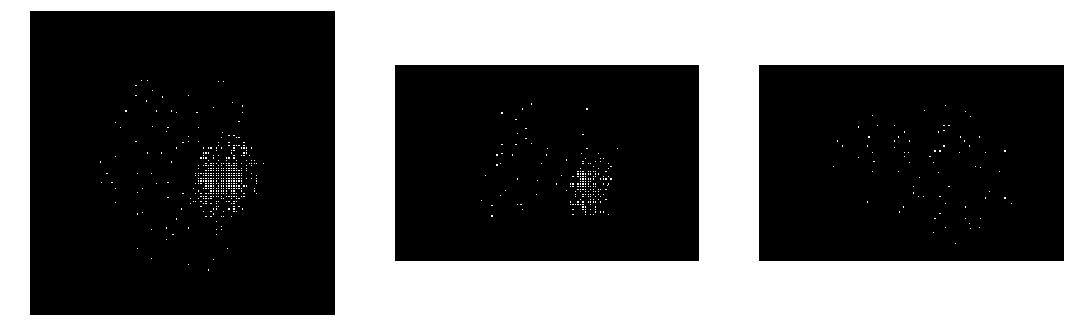

In [46]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)
x = 80
y = 100
z = 90
axs[0].imshow(mask[x,:,:],interpolation="nearest", cmap = 'gray')
axs[0].set_axis_off()
axs[1].imshow(np.flipud(mask[:,y,:]),interpolation="nearest", cmap = 'gray')
axs[1].set_axis_off()
axs[2].imshow(np.flipud(mask[:,:,z]),interpolation="nearest", cmap = 'gray')
axs[2].set_axis_off()

In [26]:
# create and store the training patches per case(patient timepoint)
import h5py
import os
import preprocessor as prep

PTHPREP = PTHORIG + '_NS'#'_BFC_HMF4'
bratsDB = prep.loadBRATS(PTHPREP)

PTHPATCH = PTHPREP+'_PATCH'
print PTHPATCH

patchtype= '3D'
patchSize = 5

tic()
# for stype in ['HGG']:#
#     for icase in [0]:#
for stype in ['HGG','LGG']:#
    for icase in range(len(bratsDB[stype])):
            # get the images and GTs
            listFile = {}
            for smod in {'T1','T1c','T2','FLAIR','GT'}:
                listFile[smod] = '%s/%s'%(PTHPREP,bratsDB[stype][icase][smod])
            
            # get the patches
            if patchtype=='triplanar':
                __patchesA,__patchesC,__patchesS,__labels, _mask = n_patchGenerator(listFile,patchSize,patchtype, maxratio=2)
            else:
                __patches,__labels, _mask = n_patchGenerator(listFile,patchSize,patchtype, maxratio=2)
            
            # shuffle
            if patchtype=='triplanar':
                inds = np.arange(__patchesA.shape[0])
                shuffle(inds)
                patchesA = __patchesA[inds,...]
                patchesC = __patchesC[inds,...]
                patchesS = __patchesS[inds,...]
                labels = __labels[inds,...]
                coords = np.flatnonzero(_mask)
                #coords = np.unravel_index(coords[inds],_mask.shape)
                coords = coords[inds,...]
                del __patchesA, __patchesC, __patchesS, _mask
            else:
                inds = np.arange(__patches.shape[0])
                shuffle(inds)
                patches = __patches[inds,...]
                labels = __labels[inds,...]
                coords = np.flatnonzero(_mask)
                #coords = np.unravel_index(coords[inds],_mask.shape)
                coords = coords[inds,...]
                del __patches, _mask
            
            # store 
            outputFile = '%s/%s'%(PTHPATCH,bratsDB[stype][icase]['GT'])
            outputDir = os.path.abspath(os.path.join(os.path.dirname( outputFile ), os.pardir))#os.path.dirname(outputFile)
            outputFile = '%s/TrainingPatches%d_%s.hdf5'%(outputDir,patchSize,patchtype)
            print 'creating '+outputFile
            if not os.path.isdir(outputDir):
                os.makedirs(outputDir)
            with h5py.File(outputFile,'w') as patchFile:
                if patchtype=='triplanar':
                    _patchesA = patchFile.create_dataset('axial_data', data = patchesA,dtype='float32',compression="gzip")
                    _patchesC = patchFile.create_dataset('coronal_data', data = patchesC,dtype='float32',compression="gzip")
                    _patchesS = patchFile.create_dataset('sagittal_data', data = patchesS,dtype='float32',compression="gzip")
                else:
                    _patches = patchFile.create_dataset('data', data = patches,dtype='float32',compression="gzip")
                _labels = patchFile.create_dataset('labels', data = labels,dtype='uint8',compression="gzip")
                _coords = patchFile.create_dataset('coords', data = coords,dtype='uint32',compression="gzip")
#             del patches
#             break # demo only
toc()

/home/disk1/alfiia//BRATS2015_Training/original_NS_PATCH
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0001_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0002_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0003_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0004_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0005_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0006_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0007_1/TrainingPatches5_3D.hdf5
creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0008_1/TrainingPatches5_3D.hdf5
creating /home/disk1/al

In [11]:
print len(bratsDB[stype])

54


In [12]:
coords = np.flatnonzero(_mask)
print coords

NameError: name '_mask' is not defined

In [36]:
outputFile = '/home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0001_1/TrainingPatches5_3D.hdf5'
with h5py.File(outputFile,'r') as patchFile:
    coords = patchFile.get('coords')
    print coords[:10]
    print patchFile.get('labels')

[5102496 5035513 3823276 3254016 3595284 4584815 5000969 5106812 3432311
 3832398]
<HDF5 dataset "labels": shape (40763,), type "|u1">


In [14]:
x,y,z = 100,100,100
# plotImage(listFile['GT'],x,y,z)

GT = sitk.GetArrayFromImage(sitk.ReadImage(listFile['GT']))
print sum(GT==1),sum(GT==2),sum(GT==3),sum(GT==4)

GT = 10*mask+GT
imshow(GT[90,:,:])
print sum(labels==0),sum(labels==1),sum(labels==2),sum(labels==3),sum(labels==4)
print patches.shape

26371 53050 818 31485


NameError: name 'mask' is not defined

4


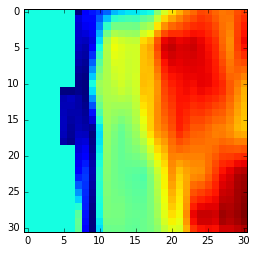

In [25]:
imshow(patchesC[19,1,...], interpolation='nearest')
print labels[19]

In [32]:
print range(len(bratsDB['LGG']))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [34]:
# create the whole train patch DBs (validation will be defined after shuffling)
import os
import preprocessor as prep
import h5py

PTHPREP = PTHORIG+'_NS' # +'_BFC' +'_BFC_HMF'
PTHPATCH = PTHPREP+'_PATCH'
PTHTRIAL = PTHPREP+'_TRIALS'

bratsDB = prep.loadBRATS(PTHPREP)#PTHPREP

patchtype='triplanar'#'triplanar'
patchSize = 31#31
listImages = {}
modNames = {'train', 'test'}
caseList = {'train':{'HGG':[],'LGG':[]},'test':{'HGG':[],'LGG':[]}}

# training cases
caseList['train']['HGG']=list(range(0,20))
caseList['train']['LGG']=list(range(0,10))

# test cases
caseList['test']['HGG']=list(range(20,30))
caseList['test']['LGG']=list(range(10,20))

# the patch dataset for the trial/experiment
if not os.path.isdir(PTHTRIAL):
    os.makedirs(PTHTRIAL)
    
tic()
# training
src_db='%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
with h5py.File(src_db,'w') as f:
    npatches = 0
    bfirst = True
    for smods in ['train']:
        for stype in ['HGG','LGG']:#
            #for icase in [0]:#demo only
            #for icase in range(len(caseList[smods][stype])):
            for icase in range(len(bratsDB[stype])):

                outputFile = '%s/%s'%(PTHPATCH,bratsDB[stype][icase]['GT'])
                outputDir = os.path.abspath(os.path.join(os.path.dirname( outputFile ), os.pardir))#os.path.dirname(outputFile)
                outputFile = '%s/TrainingPatches%d_%s.hdf5'%(outputDir,patchSize,patchtype)
                print 'processing '+outputFile
                with h5py.File(outputFile,'r') as patchFile:
                    if patchtype=='triplanar':
                        dataA = patchFile.get('axial_data')
                        dataC = patchFile.get('coronal_data')
                        dataS = patchFile.get('sagittal_data')
                    else:
                        data = patchFile.get('data')
                    labels = patchFile.get('labels')
                    coords = patchFile.get('coords')
                    if patchtype=='triplanar':
                        _datashape = list(patchFile.get('axial_data').shape)
                    else:
                        _datashape = list(patchFile.get('data').shape)
                    _labelshape = list(patchFile.get('labels').shape)
                    if bfirst:
                        maxshape = [None]
                        maxshape.extend(list(_datashape[1:]))
                        if patchtype=='triplanar':
                            dataWholeA = f.create_dataset('axial_data',_datashape,maxshape=maxshape,dtype=patchFile.get('axial_data').dtype,compression="gzip")
                            dataWholeC = f.create_dataset('coronal_data',_datashape,maxshape=maxshape,dtype=patchFile.get('coronal_data').dtype,compression="gzip")
                            dataWholeS = f.create_dataset('sagittal_data',_datashape,maxshape=maxshape,dtype=patchFile.get('sagittal_data').dtype,compression="gzip")
                        else:
                            dataWhole = f.create_dataset('data',_datashape,maxshape=maxshape,dtype=patchFile.get('data').dtype,compression="gzip")
                        maxshape = [None]
                        maxshape.extend(list(_labelshape[1:]))
                        labelsWhole = f.create_dataset('labels',_labelshape,maxshape=maxshape,dtype=patchFile.get('labels').dtype,compression="gzip")
                        coordsWhole = f.create_dataset('coords',_labelshape,maxshape=maxshape,dtype=patchFile.get('coords').dtype,compression="gzip")
                        bfirst = False
                        _cumdatashape = _datashape
                        _cumlabelshape = _labelshape
                    else:
                        _cumdatashape[0] += _datashape[0]
                        _cumlabelshape[0] += _labelshape[0]
                        if patchtype=='triplanar':
                            dataWholeA.resize(_cumdatashape)
                            dataWholeC.resize(_cumdatashape)
                            dataWholeS.resize(_cumdatashape)
                        else:
                            dataWhole.resize(_cumdatashape)
                        labelsWhole.resize(_cumlabelshape)
                        coordsWhole.resize(_cumlabelshape)

                    if patchtype=='triplanar':
                        dataWholeA[npatches:,...] = dataA
                        dataWholeC[npatches:,...] = dataC
                        dataWholeS[npatches:,...] = dataS
                    else:
                        dataWhole[npatches:,...] = data
                    labelsWhole[npatches:,...] = labels
                    coordsWhole[npatches:,...] = coords

                    npatches += _datashape[0]
toc()

processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0001_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0002_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0003_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0004_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0005_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0006_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0007_1/TrainingPatches31_triplanar.hdf5
processing /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0008_1/TrainingPatches31_triplanar.hdf5


In [4]:
PTHPREP = PTHORIG+'_NS'#'_BFC_HMF4' # +'_BFC' +'_BFC_HMF'
PTHPATCH = PTHPREP+'_PATCH'
PTHTRIAL = PTHPREP+'_TRIALS'
bratsDB = prep.loadBRATS(PTHPREP)#PTHPREP
src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)

NameError: name 'patchSize' is not defined

In [31]:
print (bratsDB[stype][icase]['T1'])
print list(range(0,20))
uIDs_HGG = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,43,44,45,46,47,48,49,50,51,59,60,61,62,63,64,65,66,67,68,69,71,72,73,74,75,76,77,78,79,80,81,83,85,90,91,92,93,94,95,96,97,103,104,105,106,107,109,110,115,116,117,123,127,128,129,130,131,132,133,134,135,136,137,138,145,146,154,155,157,158,159,160,161,162,169,179,180,181,182,183,184,185,187,188,189,190,191,192,193,194,195,199,204,207,208,209,210,211,212,213,214,215,216,217,218,219]
print uIDs_HGG
uIDs_LGG = range(54)
print uIDs_LGG

LGG/brats_tcia_pat493_0001/VSD.Brain.XX.O.MR_T1.36608/VSD.Brain.XX.O.MR_T1.36608.mha
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 43, 44, 45, 46, 47, 48, 49, 50, 51, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 90, 91, 92, 93, 94, 95, 96, 97, 103, 104, 105, 106, 107, 109, 110, 115, 116, 117, 123, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 145, 146, 154, 155, 157, 158, 159, 160, 161, 162, 169, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 199, 204, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [39]:
# create the whole train patch DBs (with additional inter-patient shuffling) (single .hdf5)
import os
import h5py
import preprocessor as prep

PTHPREP = PTHORIG+'_NS'#'_BFC_HMF4' # +'_BFC' +'_BFC_HMF'
PTHPATCH = PTHPREP+'_PATCH'
PTHTRIAL = PTHPREP+'_TRIALS'

bratsDB = prep.loadBRATS(PTHPREP)#PTHPREP

patchtype='3D'
patchSize = 5
listImages = {}
modNames = {'train', 'test'}
caseList = {'train':{'HGG':[],'LGG':[]},'test':{'HGG':[],'LGG':[]}}

# training cases
caseList['train']['HGG']=uIDs_HGG#list(range(0,20))
caseList['train']['LGG']=uIDs_LGG#list(range(0,10))

# test cases
caseList['test']['HGG']=list(range(20,30))
caseList['test']['LGG']=list(range(10,20))

# the patch dataset for the trial/experiment
if not os.path.isdir(PTHTRIAL):
    os.makedirs(PTHTRIAL)

# the size of the future dataset:
npatches = 0
nfiles = 0
listPaths = {}
for smods in ['train']:
    for stype in ['HGG','LGG']:#
        #for icase in [0,1]:
        for icase in range(len(caseList[smods][stype])):
            outputFile = '%s/%s'%(PTHPATCH,bratsDB[stype][icase]['FLAIR'])
            outputDir = os.path.abspath(os.path.join(os.path.dirname( outputFile ), os.pardir))#os.path.dirname(outputFile)
            outputFile = '%s/TrainingPatches%d_%s.hdf5'%(outputDir,patchSize,patchtype)

            with h5py.File(outputFile,'r') as patchFile:
                listPaths[nfiles] = outputFile
                nfiles += 1 
                if patchtype == 'triplanar':
                    _datashape = patchFile.get('axial_data').shape
                else:
                    _datashape = patchFile.get('data').shape
                _labelshape = patchFile.get('labels').shape
                if patchtype == 'triplanar':
                    _datatype = patchFile.get('axial_data').dtype
                else:
                    _datatype=patchFile.get('data').dtype
                _labeltype=patchFile.get('labels').dtype
                _coordshape = patchFile.get('coords').shape
                _coordstype=patchFile.get('coords').dtype
                assert(_datashape[0]==_labelshape[0])
                npatches += _datashape[0]
                #print npatches

# how much patches to load per batch:
DSET_MAX = 2147483647#sys.maxint # in caffe currently INT_MAX or 2GB per blob
print DSET_MAX
# number of float32 patches that fit in DSET_MAX chunk:
patchmax = DSET_MAX/(prod(_datashape[1:])*4)
# the fraction of all data that it takes:
FRAC = min(1.0,1.0*patchmax/npatches)
print FRAC

npatches = min(npatches, 1000000)
print 'npatches: ', npatches

_shape = [npatches]
_shape.extend(list(_datashape[1:]))
_datashape = _shape

_shape = [npatches]
_shape.extend(list(_labelshape[1:]))
_labelshape = _shape

_shape = [npatches]
_shape.extend(list(_coordshape[1:]))
_coordshape = _shape

print _datashape, _labelshape
print listPaths[0]



tgt_db='%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
# iterate in batches:

tic()
with h5py.File(tgt_db,'w') as f:
    #dataWhole = f.create_dataset('data',_datashape,shape=_datashape,dtype=_datatype,compression="gzip")
    #labelsWhole = f.create_dataset('labels',_labelshape,shape=_labelshape,dtype=_labeldtype,compression="gzip")
    if patchtype == 'triplanar':
        _patchesA = f.create_dataset('axial_data', shape=_datashape,dtype=_datatype,compression="gzip")
        _patchesC = f.create_dataset('coronal_data', shape=_datashape,dtype=_datatype,compression="gzip")
        _patchesS = f.create_dataset('sagittal_data', shape=_datashape,dtype=_datatype,compression="gzip")
    else:
        _patches = f.create_dataset('data', shape=_datashape,dtype=_datatype,compression="gzip")

    _labels = f.create_dataset('labels', shape=_labelshape,dtype=_labeltype,compression="gzip")
    _coords = f.create_dataset('coords', shape=_coordshape,dtype=_coordstype,compression="gzip")

    bSize = patchmax
    startIndWrite = 0
    ifrac = 0
    for ibatch in range(0,npatches,bSize): # surrogate of ifrac
        #collect the batch from different files
        print 'ibatch:',ibatch
        for ifile in range(nfiles): # TODO: at random
            outputFile = listPaths[ifile]
            print 'ifile:', ifile
            with h5py.File(outputFile,'r') as patchFile:
                if patchtype == 'triplanar':
                    dataA = patchFile['axial_data']
                    dataC = patchFile['coronal_data']
                    dataS = patchFile['sagittal_data']
                else:
                    data = patchFile['data']
                labels = patchFile['labels']
                coords = patchFile['coords']

                fileN = patchFile.get('labels').shape[0]
                
                print fileN
                startIndRead = int(floor(1.0*ifrac*FRAC*fileN))
                endIndRead = min(int(floor(1.0*(ifrac+1)*FRAC*fileN)), fileN)

                endIndWrite = min(npatches,startIndWrite+(endIndRead-startIndRead))
                
                endIndRead = startIndRead+endIndWrite-startIndWrite #when we don't write all the patches

                print startIndRead, endIndRead
                print startIndWrite, endIndWrite

                # write
                # update the target database:
                if patchtype == 'triplanar':
                    _patchesA[startIndWrite:endIndWrite,...] = dataA[startIndRead:endIndRead,...]
                    _patchesC[startIndWrite:endIndWrite,...] = dataC[startIndRead:endIndRead,...]
                    _patchesC[startIndWrite:endIndWrite,...] = dataS[startIndRead:endIndRead,...]
                else:
                    _patches[startIndWrite:endIndWrite,...] = data[startIndRead:endIndRead,...]
                _labels[startIndWrite:endIndWrite,...] = labels[startIndRead:endIndRead,...]
                _coords[startIndWrite:endIndWrite,...] = coords[startIndRead:endIndRead,...]

                #update the cursors
                startIndWrite = endIndWrite
                if endIndWrite==npatches:
                    break
                #break
        ifrac += 1      
toc()

2147483647
0.448945246827
npatches:  1000000
[1000000, 4, 5, 5, 5] [1000000]
/home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0001_1/TrainingPatches5_3D.hdf5
ibatch: 0
ifile: 0
40763
0 18300
0 18300
ifile: 1
1792
0 804
18300 19104
ifile: 2
5551
0 2492
19104 21596
ifile: 3
27100
0 12166
21596 33762
ifile: 4
8406
0 3773
33762 37535
ifile: 5
49003
0 21999
37535 59534
ifile: 6
7504
0 3368
59534 62902
ifile: 7
5553
0 2492
62902 65394
ifile: 8
11628
0 5220
65394 70614
ifile: 9
623
0 279
70614 70893
ifile: 10
10386
0 4662
70893 75555
ifile: 11
1211
0 543
75555 76098
ifile: 12
301
0 135
76098 76233
ifile: 13
4644
0 2084
76233 78317
ifile: 14
10955
0 4918
78317 83235
ifile: 15
19301
0 8665
83235 91900
ifile: 16
17815
0 7997
91900 99897
ifile: 17
23671
0 10626
99897 110523
ifile: 18
15791
0 7089
110523 117612
ifile: 19
28197
0 12658
117612 130270
ifile: 20
25693
0 11534
130270 141804
ifile: 21
5419
0 2432
141804 144236
ifile: 22
25600
0 11492
144236 155728
ifile: 23
8496

In [28]:
print endIndWrite-startIndWrite, endIndRead-startIndRead,
print startIndRead+endIndWrite-startIndWrite#, 1525+1e6-endIndWrite

1000 2387 1000


In [11]:
print 1/FRAC

17.0729465002


In [13]:
# shuffled data: training[+validation] (single .hdf5) (!DO NOT USE ON LARGE DATA!)
PTHPREP = PTHORIG+'_NS'# +'_BFC' +'_BFC_HMF'
PTHTRIAL = PTHPREP+'_TRIALS'

import random
import h5py
import numpy as np

patchSize = 31
patchtype = 'triplanar'
src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
shuffled_db = '%s/ShuffledWholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
# shuffled_val = '%s/ShuffledWholeValidationPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
PROC = .80 # training sample fraction

tic()
with h5py.File(src_db,'r') as f:
    # extract data from hdf file
    if patchtype == 'triplanar':
        dataA = f['axial_data']
        dataC = f['coronal_data']
        dataS = f['sagittal_data']
    else:
        data = f['data']
    labels = f['labels']
    coords = f['coords']
    
    if patchtype == 'triplanar':
        n = f.get('axial_data').shape[0]
    else:
        n = f.get('data').shape[0]
    inds = np.arange(n)
    random.shuffle(inds)
    print inds
    bSize = 100 # dont set too high due to sorting later, ideally - minimal batchsize for training
    
    # create the training
#     N = int(n*PROC)
    # create the shuffled
    N = n
    print N,n
    with h5py.File(shuffled_db,'w') as f_sh:
        _shape = [N]
        if patchtype == 'triplanar':
            _shape.extend(list(f.get('axial_data').shape[1:]))
        else:
            _shape.extend(list(f.get('data').shape[1:]))
        print _shape
        
        if patchtype == 'triplanar':
            _patchesA = f_sh.create_dataset('axial_data', shape=_shape,dtype=f.get('axial_data').dtype,compression="gzip")
            _patchesC = f_sh.create_dataset('coronal_data', shape=_shape,dtype=f.get('coronal_data').dtype,compression="gzip")
            _patchesS = f_sh.create_dataset('sagittal_data', shape=_shape,dtype=f.get('sagittal_data').dtype,compression="gzip")
        else:
            _patches = f_sh.create_dataset('data', shape=_shape,dtype=f.get('data').dtype,compression="gzip")
        _shape = [N]
        _shape.extend(list(f.get('labels').shape[1:]))
        print _shape
        _labels = f_sh.create_dataset('labels', shape=_shape,dtype=f.get('labels').dtype,compression="gzip")
        _shape = [N]
        _shape.extend(list(f.get('coords').shape[1:]))
        _coords = f_sh.create_dataset('coords', shape=_shape,dtype=f.get('coords').dtype,compression="gzip")
        
        if patchtype == 'triplanar':
            nppatchesA = np.zeros(f_sh.get('axial_data').shape,dtype=f.get('axial_data').dtype)
            nppatchesC = np.zeros(f_sh.get('coronal_data').shape,dtype=f.get('coronal_data').dtype)
            nppatchesS = np.zeros(f_sh.get('sagittal_data').shape,dtype=f.get('sagittal_data').dtype)
        else:
            nppatches = np.zeros(f_sh.get('data').shape,dtype=f.get('data').dtype)
        nplabels = np.zeros(f_sh.get('labels').shape,dtype=f.get('labels').dtype)
        npcoords = np.zeros(f_sh.get('coords').shape,dtype=f.get('coords').dtype)

        # record the shuffled data one by one
        for ibatch in range(0,N,bSize):
            #tic()
            newinds = (inds[ibatch:min(ibatch+bSize,N)])
            if patchtype == 'triplanar':
                nppatchesA[newinds,...] = dataA[ibatch:min(ibatch+bSize,N),...]
                nppatchesC[newinds,...] = dataC[ibatch:min(ibatch+bSize,N),...]
                nppatchesS[newinds,...] = dataS[ibatch:min(ibatch+bSize,N),...]
            else:
                nppatches[newinds,...] = data[ibatch:min(ibatch+bSize,N),...]
            nplabels[newinds,...] = labels[ibatch:min(ibatch+bSize,N),...]
            npcoords[newinds,...] = coords[ibatch:min(ibatch+bSize,N),...]
            #toc()
        if patchtype == 'triplanar':
            _patchesA[:] = nppatchesA
            _patchesC[:] = nppatchesC
            _patchesS[:] = nppatchesS
        else:
            _patches[:] = nppatches
        _labels[:] = nplabels
        _coords[:] = npcoords
        
toc()

#     # create the validation
#     N = n-int(n*PROC)
#     with h5py.File(shuffled_val,'w') as f_sh:
#         _shape = [N]
#         _shape.extend(list(f.get('data').shape[1:]))
#         print _shape
#         _patches = f_sh.create_dataset('data', shape=_shape,dtype=f.get('data').dtype,compression="gzip")
#         _shape = [N]
#         _shape.extend(list(f.get('labels').shape[1:]))
#         print _shape
#         _labels = f_sh.create_dataset('labels', shape=_shape,dtype=f.get('labels').dtype,compression="gzip")
#         # record the shuffled data one by one
#         for ibatch in range(0,N,bSize):
#             newinds = sort(inds[ int(n*PROC)+ibatch:int(n*PROC)+min(ibatch+bSize,N) ])
#             _patches[ibatch:min(ibatch+bSize,N),...] = data[newinds,...]
#             _labels[ibatch:min(ibatch+bSize,N),...] = labels[newinds,...]

[318176 336613  53231 ...,  26922 316358 419074]
429939 429939
[429939, 4, 31, 31]
[429939]
Elapsed time is 3102.58283877 seconds.


In [8]:
src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
with h5py.File(src_db,'r') as f:
    f.get([labels])

IOError: Unable to open file (File signature not found)

In [8]:
imshow(nppatchesC[5,2,...], interpolation='nearest')
print npcoords

[6352934 3830010 3383418 ..., 5907986 5724867 4409375]


In [15]:
import h5py
PTHPREP = PTHORIG+'_BFC_HMF4' # +'_BFC' +'_BFC_HMF'
PTHTRIAL = PTHPREP+'_TRIALS'
patchSize = 31
patchtype = 'triplanar'
src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
shuffled_db = '%s/ShuffledWholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
#shuffled_db = '%s/ShuffledWholeTrainingPatches%d_%s.h5list'%(PTHTRIAL,patchSize,patchtype)
#shuffled_val = '%s/ShuffledWholeValidationPatches%d_%s.h5list'%(PTHTRIAL,patchSize,patchtype)
PROC = .80 # training sample fraction

print PTHPREP
tic()
with h5py.File(shuffled_db,'r') as f:
    # extract data from hdf file
    #data = f['data']
    labels = f['labels']
    if patchtype == 'triplanar':
        n = f.get('axial_data').shape[0]
        print f.get('coords').shape
    else:
        n = f.get('data').shape[0]
    
import json
#jsonFile = '%s/%s'%(PTHTRIAL, 'n_train_val.json')
jsonFile = '%s/%s'%(PTHTRIAL, 'n_train_val%d_%s.json'%(patchSize,patchtype))

with open(jsonFile, 'w') as fp:
    json.dump({'nTrain':int(n*PROC),'nVal':n-int(n*PROC)}, fp)

/home/disk1/alfiia//BRATS2015_Training/original_BFC_HMF4
(429939,)


In [40]:
# TRAINING+VALIDATION datasets (as .h5list for caffe)

# shuffled data: training+validation
PTHPREP = PTHORIG+'_NS' # +'_BFC' +'_BFC_HMF'
PTHTRIAL = PTHPREP+'_TRIALS'

import random
import h5py
import os
import numpy as np

patchSize = 5
patchtype = '3D'
src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
shuffled_db = '%s/ShuffledWholeTrainingPatches%d_%s.h5list'%(PTHTRIAL,patchSize,patchtype)
shuffled_val = '%s/ShuffledWholeValidationPatches%d_%s.h5list'%(PTHTRIAL,patchSize,patchtype)
PROC = .80 # training sample fraction

print PTHPREP
tic()
with h5py.File(src_db,'r') as f:
    # extract data from hdf file
    if patchtype == 'triplanar':
        dataA = f['axial_data']
        dataC = f['coronal_data']
        dataS = f['sagittal_data']
    else:
        data = f['data']
    labels = f['labels']
    coords = f['coords']
    if patchtype == 'triplanar':
        n = f.get('axial_data').shape[0]
    else:
        n = f.get('data').shape[0]
    inds = np.arange(n)
#     random.shuffle(inds)
    print inds
    bSize = 100 # dont set too high due to sorting later, ideally - minimal batchsize for training
    
    DSET_MAX = 2147483647#sys.maxint # in caffe currently INT_MAX or 2GB per blob
    print DSET_MAX
    if patchtype == 'triplanar':
        _datashape = f.get('axial_data').shape
    else:
        _datashape = f.get('data').shape
    # number of float32 patches that fit in DSET_MAX chunk:
    patchmax = DSET_MAX/(prod(_datashape[1:])*4)
        
    # create the training
    pathname, _ = os.path.splitext(shuffled_db)
    #create a directory where the .hdf5 files will be stored:
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    filename, _ = os.path.splitext( os.path.basename(shuffled_db) )
    file_ext = '.hdf5' # could be '.h5'
    dirname = filename
    
    N = int(n*PROC)
    print N,n
    
    #go through as much files as needed
    with open(shuffled_db, "w") as text_file:
        cumpatch = 0; ifile = 0

        #go through hdf5-files
        while cumpatch<N:
            patchFileName = '%s/%s_%d%s'%(pathname,filename,ifile,file_ext)
            text_file.write('%s/%s\n'%(dirname,os.path.basename(patchFileName)))
            print 'creating '+os.path.basename(patchFileName)
            tic()
            # record to an hdf5 file
            with h5py.File(patchFileName,'w') as f_sh:
                # number of patches to be written in this file:
                _npatch = min(N-cumpatch, patchmax)
                print 'patches in this file: %d'%_npatch 

#                 # assuming the shuffling will be performed by caffe
#                 newinds = sort(inds[cumpatch:cumpatch+_npatch])
#                 _patches = f_sh.create_dataset('data', data=data[newinds,...],dtype=f.get('data').dtype,compression="gzip")
#                 _labels = f_sh.create_dataset('labels', data=labels[newinds,...],dtype=f.get('labels').dtype,compression="gzip")
                
                _shape = [_npatch]
                if patchtype == 'triplanar':
                    _shape.extend(list(f.get('axial_data').shape[1:]))
                else:
                    _shape.extend(list(f.get('data').shape[1:]))
                print _shape
                if patchtype == 'triplanar':
                    _patchesA = f_sh.create_dataset('axial_data', shape=_shape,dtype=f.get('axial_data').dtype,compression="gzip")
                    _patchesC = f_sh.create_dataset('coronal_data', shape=_shape,dtype=f.get('coronal_data').dtype,compression="gzip")
                    _patchesS = f_sh.create_dataset('sagittal_data', shape=_shape,dtype=f.get('sagittal_data').dtype,compression="gzip")
                else:
                    _patches = f_sh.create_dataset('data', shape=_shape,dtype=f.get('data').dtype,compression="gzip")#,compression="gzip"
                _shape = [_npatch]
                _shape.extend(list(f.get('labels').shape[1:]))
                print _shape
                _labels = f_sh.create_dataset('labels', shape=_shape,dtype=f.get('labels').dtype,compression="gzip")#,compression="gzip"
                _shape = [_npatch]
                _shape.extend(list(f.get('coords').shape[1:]))
                print _shape
                _coords = f_sh.create_dataset('coords', shape=_shape,dtype=f.get('coords').dtype,compression="gzip")#,compression="gzip"
                            
#                 # assuming the shuffling will be performed by caffe
#                 newinds = sort(inds[cumpatch:cumpatch+_npatch])
#                 patches = data[newinds,...]
#                 labels = labels[newinds,...]
                if patchtype == 'triplanar':
                    nppatchesA = np.zeros(f_sh.get('axial_data').shape,dtype=f.get('axial_data').dtype)
                    nppatchesC = np.zeros(f_sh.get('coronal_data').shape,dtype=f.get('coronal_data').dtype)
                    nppatchesS = np.zeros(f_sh.get('sagittal_data').shape,dtype=f.get('sagittal_data').dtype)
                else:
                    nppatches = np.zeros(f_sh.get('data').shape,dtype=f.get('data').dtype)
                nplabels = np.zeros(f_sh.get('labels').shape,dtype=f.get('labels').dtype)
                npcoords = np.zeros(f_sh.get('coords').shape,dtype=f.get('coords').dtype)
                # record the shuffled data batch by batch (small batches)
                for ibatch in range(0,_npatch,bSize):
                    newinds = sort(inds[cumpatch+ibatch:min(cumpatch+ibatch+bSize,cumpatch+_npatch)])
                    if patchtype == 'triplanar':
                        nppatchesA[ibatch:min(ibatch+bSize,_npatch),...] = dataA[newinds,...]
                        nppatchesC[ibatch:min(ibatch+bSize,_npatch),...] = dataC[newinds,...]
                        nppatchesS[ibatch:min(ibatch+bSize,_npatch),...] = dataS[newinds,...]
                    else:
                        nppatches[ibatch:min(ibatch+bSize,_npatch),...] = data[newinds,...]
                    nplabels[ibatch:min(ibatch+bSize,_npatch),...] = labels[newinds,...]
                    npcoords[ibatch:min(ibatch+bSize,_npatch),...] = coords[newinds,...]
                    
                if patchtype == 'triplanar':
                    _patchesA[:] = nppatchesA
                    _patchesC[:] = nppatchesC
                    _patchesS[:] = nppatchesS
                else:
                    _patches[:] = nppatches
                _labels[:] = nplabels
                _coords[:] = npcoords
                
            toc()    
            # increment the cursor
            cumpatch = min(N, cumpatch + patchmax) 
            ifile +=1

            print cumpatch
            
    # create the validation
    pathname, _ = os.path.splitext(shuffled_val)
    #create a directory where the .hdf5 files will be stored:
    if not os.path.isdir(pathname):
        os.makedirs(pathname)
    filename, _ = os.path.splitext( os.path.basename(shuffled_val) )
    file_ext = '.hdf5' # could be '.h5'
    dirname = filename
    N = n-int(n*PROC)
    
    #go through as much files as needed
    with open(shuffled_val, "w") as text_file:
        cumpatch = int(n*PROC); ifile = 0

        #go through hdf5-files
        while cumpatch<n:
            patchFileName = '%s/%s_%d%s'%(pathname,filename,ifile,file_ext)
            text_file.write('%s/%s\n'%(dirname,os.path.basename(patchFileName)))
            print 'creating '+os.path.basename(patchFileName)

            # record to an hdf5 file
            with h5py.File(patchFileName,'w') as f_sh:
                # number of patches to be written in this file:
                _npatch = min(n-cumpatch, patchmax)
                print 'patches in this file: %d'%_npatch 

                _shape = [_npatch]
                if patchtype == 'triplanar':
                    _shape.extend(list(f.get('axial_data').shape[1:]))
                else:
                    _shape.extend(list(f.get('data').shape[1:]))
                print _shape
                if patchtype == 'triplanar':
                    _patchesA = f_sh.create_dataset('axial_data', shape=_shape,dtype=f.get('axial_data').dtype,compression="gzip")
                    _patchesC = f_sh.create_dataset('coronal_data', shape=_shape,dtype=f.get('coronal_data').dtype,compression="gzip")
                    _patchesS = f_sh.create_dataset('sagittal_data', shape=_shape,dtype=f.get('sagittal_data').dtype,compression="gzip")
                else:
                    _patches = f_sh.create_dataset('data', shape=_shape,dtype=f.get('data').dtype)#,compression="gzip"
                _shape = [_npatch]
                _shape.extend(list(f.get('labels').shape[1:]))
                print _shape
                _labels = f_sh.create_dataset('labels', shape=_shape,dtype=f.get('labels').dtype)#,compression="gzip"
                _shape = [_npatch]
                _shape.extend(list(f.get('coords').shape[1:]))
                print _shape
                _coords = f_sh.create_dataset('coords', shape=_shape,dtype=f.get('coords').dtype)#,compression="gzip"

                # record the shuffled data batch by batch (small batches)
                for ibatch in range(0,_npatch,bSize):
                    newinds = sort(inds[cumpatch+ibatch:min(cumpatch+ibatch+bSize,cumpatch+_npatch)])
                    if patchtype == 'triplanar':
                        _patchesA[ibatch:min(ibatch+bSize,_npatch),...] = dataA[newinds,...]
                        _patchesC[ibatch:min(ibatch+bSize,_npatch),...] = dataC[newinds,...]
                        _patchesS[ibatch:min(ibatch+bSize,_npatch),...] = dataS[newinds,...]
                    else:
                        _patches[ibatch:min(ibatch+bSize,_npatch),...] = data[newinds,...]
                    _labels[ibatch:min(ibatch+bSize,_npatch),...] = labels[newinds,...]
                    _coords[ibatch:min(ibatch+bSize,_npatch),...] = coords[newinds,...]

            # increment the cursor
            cumpatch = min(n, cumpatch + patchmax) 
            ifile +=1

            print cumpatch


/home/disk1/alfiia//BRATS2015_Training/original_NS
[     0      1      2 ..., 999997 999998 999999]
2147483647
800000 1000000
creating ShuffledWholeTrainingPatches5_3D_0.hdf5
patches in this file: 800000
[800000, 4, 5, 5, 5]
[800000]
[800000]
Elapsed time is 2702.78195095 seconds.
800000
creating ShuffledWholeValidationPatches5_3D_0.hdf5
patches in this file: 200000
[200000, 4, 5, 5, 5]
[200000]
[200000]
1000000


In [41]:

# from preprocessor import _patchExtractor
def _patchExtractor(inputFile, GTFile, masktype='brainmask', stride=2, minclass=0.01, bzscores=False):
    
    inputImage = sitk.ReadImage(inputFile)
    data = sitk.GetArrayFromImage(inputImage)
    
    if bzscores:
        IC=scipy.ndimage.filters.median_filter(data,3)!=0 # intracranial volume
    else:
        IC=scipy.ndimage.filters.median_filter(data,3)>0
        
    if not masktype == 'all':
        GTImage = sitk.ReadImage(GTFile)
        maskGT = sitk.GetArrayFromImage(GTImage)
    if masktype == 'brainmask':
        chess = _patchSampler(GTFile,s=stride)
        chessNABS = _patchSampler(GTFile,s=4,bRandom=True)
        mask = (chess>0) & (maskGT>0) | ((chessNABS>0) & (maskGT==0) & (IC>0))
    elif masktype == 'bbox':
        chess = _patchSampler(GTFile,s=2)
        [IZ,IR,IC]=np.where(maskGT>0)
        minZ = min(IZ)
        minR = min(IR)
        minC = min(IC)

        maxZ = max(IZ)
        maxR = max(IR)
        maxC = max(IC)

        bbox = np.zeros(maskGT.shape)
        bbox[range(minZ,maxZ),:,:]=1
        bbox[:,range(minR,maxR)]+=1
        bbox[:,:,range(minC,maxC)]+=1

        mask = (chess>0) & (bbox>2) & (IC>0)
    elif masktype == 'all':#for segmentation test
        mask = (IC>0)

    if not masktype == 'all':
        # remove the under-respresented:
        for lab in unique(maskGT.flatten()):
            if float(sum(maskGT == lab))/sum(maskGT>0) < minclass:
                mask[maskGT == lab] = 0

    return mask

def _patchGenerator(listFile, patchSize, patchtype='axial', masktype='bbox',outputFile=''):
    assert(not patchSize % 2 == 0)
    nChannels = 4 #'FLAIR','T1c','T2','T1'
    PS = patchSize/2
    imageFile = listFile['FLAIR']
    GTFile = listFile['GT']
    mask = _patchExtractor(imageFile, GTFile, masktype, bzscores=True)

    [IZZ,IRR,ICC] = np.where(mask>0)
    npatch = size(IZZ)

    # if needed, record directly to the output file
    if not outputFile=='' and ('.h5list' in outputFile or '.txt' in outputFile):
        # write into several (as needed) hdf files and record them as a list in txt
        import h5py
        import sys
        DSET_MAX = 2147483647#sys.maxint # in caffe currently INT_MAX or 2GB per blob
        
        if patchtype in {'axial','coronal','sagittal','triplanar'}:
            _datashape = [npatch,nChannels,patchSize,patchSize]
        #elif patchtype=='triplanar':
        #    _datashape = [npatch,nChannels*3,patchSize,patchSize]
        elif patchtype=='3D':
            _datashape = [npatch,nChannels,patchSize,patchSize,patchSize]
        _labelshape = [npatch]
        _coordshape = [npatch]
        
        # number of float32 patches that fit in DSET_MAX chunk:
        patchmax = DSET_MAX/(prod(_datashape[1:])*4)
        
        import os
        pathname, _ = os.path.splitext(outputFile)
        #create a directory where the .hdf5 files will be stored:
        if not os.path.isdir(pathname):
            os.makedirs(pathname)
        filename, _ = os.path.splitext( os.path.basename(outputFile) )
        file_ext = '.hdf5' # could be '.h5'
        dirname = filename

        #go through as much files as needed
        with open(outputFile, "w") as text_file:
            cumpatch = 0; ifile = 0
            
            bSize = min(npatch,10000) # it is continuos (no shuffling), should be ok 
                            
            # load the multi-modal images
            imageChannelCount = 0
            NDA = []
            for smod in {'FLAIR','T1c','T2','T1'}:
                inputImage = sitk.ReadImage(listFile[smod])
                nda = np.float32(sitk.GetArrayFromImage(inputImage))
                # compute z-scores ('standardization')
                ind = np.where(nda>0)
                nda[ind] = (nda[ind] - np.mean(nda[ind]))/(np.std(nda[ind])+np.finfo(float).eps)
                nda = np.lib.pad(nda,((PS,PS),(PS,PS),(PS,PS)), 'constant',constant_values=(0,0))
                NDA.append(nda)
            if not listFile['GT']=='':
                GT = sitk.ReadImage(listFile['GT'])
                GT = sitk.GetArrayFromImage(GT)
                GT = GT[mask>0]
            coords = np.flatnonzero(mask)
                
            #go through hdf5-files
            while cumpatch<npatch:
                patchFileName = '%s/%s_%d%s'%(pathname,filename,ifile,file_ext)
                text_file.write('%s/%s\n'%(dirname,os.path.basename(patchFileName)))
                print 'creating '+os.path.basename(patchFileName)
                
                import h5py
                with h5py.File(patchFileName,'w') as patchFile:
                    # number of patches to be written in this file:
                    _npatch = min(npatch-cumpatch, patchmax)
                    print 'patches in this file: %d'%min(npatch-cumpatch, patchmax) 
                    
                    _shape = _datashape
                    _shape[0] = _npatch
                    if patchtype in {'triplanar'}:
                        _patchesA = patchFile.create_dataset('axial_data', shape=_shape,dtype='float32',compression="gzip")
                        _patchesC = patchFile.create_dataset('coronal_data', shape=_shape,dtype='float32',compression="gzip")
                        _patchesS = patchFile.create_dataset('sagittal_data', shape=_shape,dtype='float32',compression="gzip")
                    else:
                        _patches = patchFile.create_dataset('data', shape=_shape,dtype='float32',compression="gzip")
                    _shape = _labelshape
                    _shape[0] = _npatch
                    _labels = patchFile.create_dataset('labels', shape=_shape,dtype='uint8',compression="gzip")
                    _coords = patchFile.create_dataset('coords', shape=_shape,dtype='uint32',compression="gzip")
            
                    for ibatch in range(0,_npatch,bSize):
                        _shape = _datashape
                        _shape[0] = min(bSize,_npatch-ibatch)
                        if patchtype in {'triplanar'}:
                            patchesA = np.zeros(_shape)
                            patchesC = np.zeros(_shape)
                            patchesS = np.zeros(_shape)
                        else:
                            patches = np.zeros(_shape)
                        print ibatch/float(bSize),_shape 
                        for imageChannelCount in range(nChannels):
                            nda = NDA[imageChannelCount]
                            for ipatch in range(_shape[0]):
                                z = IZZ[cumpatch+ibatch+ipatch]+PS 
                                i = IRR[cumpatch+ibatch+ipatch]+PS
                                j = ICC[cumpatch+ibatch+ipatch]+PS
                                if patchtype=='axial':
                                    patches[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                                elif patchtype=='coronal':
                                    patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                                elif patchtype=='sagittal':
                                    patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                                elif patchtype=='triplanar':
                                    patchesA[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                                    patchesC[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                                    patchesS[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                                    #patches[ipatch,imageChannelCount*3,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                                    #patches[ipatch,imageChannelCount*3+1,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                                    #patches[ipatch,imageChannelCount*3+2,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                                elif patchtype=='3D':
                                    patches[ipatch,imageChannelCount,:,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j-PS:j+PS+1]
                        if patchtype in {'triplanar'}:
                            _patchesA[ibatch:min(ibatch+bSize,_npatch),...] = patchesA
                            _patchesC[ibatch:min(ibatch+bSize,_npatch),...] = patchesC
                            _patchesS[ibatch:min(ibatch+bSize,_npatch),...] = patchesS
                        else:
                            _patches[ibatch:min(ibatch+bSize,_npatch),...] = patches

                    # assuming a single label per patch
                    if not listFile['GT']=='':
                        _labels[:] = GT[cumpatch:min(npatch, cumpatch + patchmax)]
#                     coords = np.flatnonzero(mask)
                    #coords = np.unravel_index(coords[inds],_mask.shape)
                    _coords[:] = coords[cumpatch:min(npatch, cumpatch + patchmax)]
                
                cumpatch = min(npatch, cumpatch + patchmax) 
                ifile +=1

                print cumpatch
        
    elif not outputFile=='' and ('.h5' in outputFile or '.hdf5' in outputFile):
        # write into a single hdf5 file
        import h5py
        with h5py.File(outputFile,'w') as patchFile:
            if patchtype in {'axial','coronal','sagittal'}:
                _datashape = [npatch,nChannels,patchSize,patchSize]
            elif patchtype=='triplanar':
                _datashape = [npatch,nChannels*3,patchSize,patchSize]
            elif patchtype=='3D':
                _datashape = [npatch,nChannels,patchSize,patchSize,patchSize]
            _patches = patchFile.create_dataset('data', shape=_datashape,dtype='float32',compression="gzip")
            _labelshape = [npatch]
            _labels = patchFile.create_dataset('labels', shape=_labelshape,dtype='uint8',compression="gzip")
            
            bSize = min(npatch,10000) # it is continuos (no shuffling), should be ok 
                            
            imageChannelCount = 0
            NDA = []
            for smod in {'FLAIR','T1c','T2','T1'}:
                inputImage = sitk.ReadImage(listFile[smod])
                nda = np.float32(sitk.GetArrayFromImage(inputImage))
                # compute z-scores ('standardization')
                ind = np.where(nda>0)
                nda[ind] = (nda[ind] - np.mean(nda[ind]))/(np.std(nda[ind])+np.finfo(float).eps)
                nda = np.lib.pad(nda,((PS,PS),(PS,PS),(PS,PS)), 'constant',constant_values=(0,0))
                NDA.append(nda)
            
            
            for ibatch in range(0,npatch,bSize):
                _shape = _datashape
                _shape[0] = min(bSize,npatch-ibatch)
                patches = np.zeros(_shape)
                print ibatch/float(bSize),_shape 
                for imageChannelCount in range(nChannels):
                    nda = NDA[imageChannelCount]
                    for ipatch in range(_shape[0]):
                        z = IZZ[ibatch+ipatch]+PS; i = IRR[ibatch+ipatch]+PS; j = ICC[ibatch+ipatch]+PS
                        if patchtype=='axial':
                            patches[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                        elif patchtype=='coronal':
                            patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                        elif patchtype=='sagittal':
                            patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                        elif patchtype=='triplanar':
                            patches[ipatch,imageChannelCount*3,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                            patches[ipatch,imageChannelCount*3+1,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                            patches[ipatch,imageChannelCount*3+2,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                        elif patchtype=='3D':
                            patches[ipatch,imageChannelCount,:,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j-PS:j+PS+1]

                _patches[ibatch:min(ibatch+bSize,npatch),...] = patches

            # assuming a single label per patch
            GT = sitk.ReadImage(listFile['GT'])
            GT = sitk.GetArrayFromImage(GT)
            print unique(GT[mask>0].flatten())
            _labels[:] = GT[mask>0]

        return 
    
    else:
        if patchtype=='axial' or patchtype=='coronal' or patchtype=='sagittal':
            patches = np.zeros(shape=(npatch,nChannels,patchSize, patchSize))
        elif patchtype=='triplanar':
            patches = np.zeros(shape=(npatch,nChannels*3,patchSize, patchSize))
        elif patchtype=='3D':
            patches = np.zeros(shape=(npatch,nChannels,patchSize, patchSize,patchSize))

        imageChannelCount = 0
        for smod in {'FLAIR','T1c','T2','T1'}:
            inputImage = sitk.ReadImage(listFile[smod])
            nda = np.float32(sitk.GetArrayFromImage(inputImage))
            # compute z-scores ('standardization')
            ind = np.where(nda>0)
            nda[ind] = (nda[ind] - np.mean(nda[ind]))/(np.std(nda[ind])+np.finfo(float).eps)
            nda = np.lib.pad(nda,((PS,PS),(PS,PS),(PS,PS)), 'constant',constant_values=(0,0))
            for ipatch in range(npatch):
                z = IZZ[ipatch]+PS; i = IRR[ipatch]+PS; j = ICC[ipatch]+PS
                if patchtype=='axial':
                    patches[ipatch,imageChannelCount,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                elif patchtype=='coronal':
                    patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                elif patchtype=='sagittal':
                    patches[ipatch,imageChannelCount,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                elif patchtype=='triplanar':
                    patches[ipatch,imageChannelCount*3,:,:] = nda[z,i-PS:i+PS+1,j-PS:j+PS+1]
                    patches[ipatch,imageChannelCount*3+1,:,:] = nda[z-PS:z+PS+1,i,j-PS:j+PS+1]
                    patches[ipatch,imageChannelCount*3+2,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j]
                elif patchtype=='3D':
                    patches[ipatch,imageChannelCount,:,:,:] = nda[z-PS:z+PS+1,i-PS:i+PS+1,j-PS:j+PS+1]

            imageChannelCount += 1
        GT = sitk.ReadImage(listFile['GT'])
        GT = sitk.GetArrayFromImage(GT)
        labels = GT[mask>0]
        return patches, labels

In [ ]:
# create the test cases
import os
import preprocessor as prep

PTHPREP = PTHORIG+'_NS'#'_BFC_HMF4' # +'_BFC' +'_BFC_HMF'
PTHPATCH = PTHPREP+'_PATCH'
PTHTRIAL = PTHPREP+'_TRIALS'

bratsDB = prep.loadBRATS(PTHPREP)#PTHPREP


patchtype='3D'#'triplanar'#'axial'
patchSize = 5
listImages = {}
modNames = {'train', 'test'}
caseList = {'train':{'HGG':[],'LGG':[]},'test':{'HGG':[],'LGG':[]}}

caseList['test']['HGG']=list(range(len(bratsDB['HGG'])))#list(range(20,30))
caseList['test']['LGG']=list(range(len(bratsDB['LGG'])))#list(range(10,20))

# the patch dataset for the trial/experiment
if not os.path.isdir(PTHTRIAL):
    os.makedirs(PTHTRIAL)

# create test from scratch
for stype in ['HGG','LGG']:#,'LGG'
    for icase in caseList['test'][stype]:
            # get the images and GTs
            listFile = {}
            for smod in {'T1','T1c','T2','FLAIR','GT'}:
                listFile[smod] = '%s/%s'%(PTHPREP,bratsDB[stype][icase][smod])
            # store 
            outputFile = '%s/%s'%(PTHPATCH,bratsDB[stype][icase]['FLAIR'])
            outputDir = os.path.abspath(os.path.join(os.path.dirname( outputFile ), os.pardir))#os.path.dirname(outputFile)
            outputFile = '%s/TestPatches%d_%s.h5list'%(outputDir,patchSize,patchtype)
            print 'creating '+outputFile
            if not os.path.isdir(outputDir):
                os.makedirs(outputDir)
#             with h5py.File(outputFile,'w') as patchFile:
#                 _patches = patchFile.create_dataset('data', data = patches,dtype='float32',compression="gzip")
#                 _labels = patchFile.create_dataset('labels', data = labels,dtype='uint8',compression="gzip")
            # get the patches
            tic()
            _patchGenerator(listFile,patchSize,patchtype=patchtype, masktype='all',outputFile=outputFile)
            toc()
            #break

creating /home/disk1/alfiia/BRATS2015_Training/original_NS_PATCH/HGG/brats_2013_pat0001_1/TestPatches5_3D.h5list
creating TestPatches5_3D_0.hdf5
patches in this file: 1073741
0.0 [10000, 4, 5, 5, 5]
1.0 [10000, 4, 5, 5, 5]
2.0 [10000, 4, 5, 5, 5]
3.0 [10000, 4, 5, 5, 5]
4.0 [10000, 4, 5, 5, 5]
5.0 [10000, 4, 5, 5, 5]
6.0

In [11]:
print icase

67


In [ ]:
!dir /home/disk1/alfiia/BRATS2015_Training/original_BFC_HMF4_PATCH/LGG/

In [22]:
# verify the data and labels of patches
import h5py
# src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
#src_db = '%s/TestPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
src_db = 'C:/alfiia/projects/SU/BrainTumor/BRATS2015_Training/original_PATCH/HGG/brats_tcia_pat105_0001/TestPatches31_axial/TestPatches31_axial_0.hdf5'
with h5py.File(src_db,'r') as f:
    # extract data from hdf file
    print f.keys()
    print f.get('axial_data').shape, f.get('labels').shape
    data = f['axial_data']
    print data.dtype, f['labels'].dtype

IOError: Unable to open file (Unable to open file: name = 'c:/alfiia/projects/su/braintumor/brats2015_training/original_patch/hgg/brats_tcia_pat105_0001/testpatches31_axial/testpatches31_axial_0.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [5]:
# visualize a few patches
from pylab import *
%matplotlib inline

patchSize = 31
patchtype = 'axial'

# src_db = '%s/WholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
# src_db = '%s/TestPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
#src_db = '%s/TestPatches%d_%s.hdf5'%("C:/alfiia/projects/SU/BrainTumor/BRATS2015_Training/original_PATCH/HGG/brats_tcia_pat105_0001",patchSize,patchtype)
src_txt = '%s/TestPatches%d_%s.h5list'%("C:/alfiia/projects/SU/BrainTumor/BRATS2015_Training/original_PATCH/HGG/brats_tcia_pat105_0001",patchSize,patchtype)

with open(src_txt,'r') as f:
    for line in f:
        src_db = line
        print line
        break
os.chdir(os.path.dirname(src_txt))
src_db = 'C:/alfiia/projects/SU/BrainTumor/BRATS2015_Training/original_PATCH/HGG/brats_tcia_pat105_0001/TestPatches31_axial/TestPatches31_axial_9.hdf5'
with h5py.File(src_db,'r') as f:
    # extract data from hdf file
    print f.keys()
    print f.get('data').shape, f.get('labels').shape
    data = f['data']
    labels = f['labels']

    ind0 = 4000
    n = 2
    fig,ax = plt.subplots(n,2)
    for i in range(n):
        ax[i,0].imshow(data[ind0+i,:4,:,:].transpose(1, 0, 2).reshape(patchSize, 4*patchSize),interpolation="nearest",cmap='gray')
        ax[i,1].hist(data[ind0+i,:4,:,:].flatten())
        print(labels[ind0+i])
        
    print unique(labels)

IOError: [Errno 2] No such file or directory: 'C:/alfiia/projects/SU/BrainTumor/BRATS2015_Training/original_PATCH/HGG/brats_tcia_pat105_0001/TestPatches31_axial.h5list'

In [9]:
# visualize a few shuffled patches
from pylab import *
%matplotlib inline

patchSize = 31
patchtype = 'axial'

PTHPREP = PTHORIG+'_BFC_HMF4' # +'_BFC' +'_BFC_HMF'
PTHPATCH = PTHPREP+'_PATCH'
PTHTRIAL = PTHPREP+'_TRIALS'

src_db = '%s/ShuffledWholeTrainingPatches%d_%s.hdf5'%(PTHTRIAL,patchSize,patchtype)
# src_db = '%s/ShuffledWholeValidationPatches%d_%s.h5'%(PTHTRIAL,patchSize,patchtype)
with h5py.File(src_db,'r') as f:
    # extract data from hdf file
    print f.keys()
    print f.get('data').shape, f.get('labels').shape
    data = f['data']
    label = f['labels']

    ind0 = 3
    n = 3
    fig,ax = plt.subplots(n,2)
    for i in range(n):
        ax[i,0].imshow(data[ind0+i,:4,:,:].transpose(1, 0, 2).reshape(patchSize, 4*patchSize),interpolation="nearest",cmap='gray')
        ax[i,1].hist(data[ind0+i,:4,:,:].flatten())
        print(label[ind0+i]) 
    
    print unique(label)
    print data.dtype, label.dtype

IOError: Unable to open file (Unable to open file: name = '/home/disk1/alfiia//brats2015_training/original_bfc_hmf4_trials/shuffledwholetrainingpatches31_axial.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)